In [2]:
!pip install requests

     ---------------------------------------- 63.1/63.1 KB 3.3 MB/s eta 0:00:00
     -------------------------------------- 139.0/139.0 KB 4.2 MB/s eta 0:00:00
     ---------------------------------------- 61.2/61.2 KB ? eta 0:00:00
     -------------------------------------- 149.2/149.2 KB 9.3 MB/s eta 0:00:00


In [25]:
!pip install pandas

In [48]:
import requests
import json
import pandas as pd
import numpy as np

## 結果データを取得する

In [14]:
def getResultData(id):
    try:
        response = requests.get(f'http://localhost:5000/results/{id}')
        data = json.loads(response.text)
        
        #jsonデータをpandasのdataframeに変換する
        return data['data']
    except:
        throw('no id matches data in database')

In [16]:
resultData = getResultData(5)

In [27]:
resultData

[{'roomId': 1,
  'results': {'roomT': [29.92,
    28.94,
    28.15,
    27.52,
    27.01,
    26.59,
    26.24,
    25.96,
    23.05,
    24.23,
    24.19,
    24.24,
    24.26,
    24.26,
    24.25,
    23.32,
    22.2,
    22.0,
    22.0,
    22.0,
    30.37,
    32.46,
    32.4,
    31.55,
    29.84,
    28.85,
    28.06,
    27.42,
    26.89,
    26.47,
    26.12,
    25.85,
    23.05,
    24.21,
    24.2,
    24.28,
    24.36,
    24.41,
    24.47,
    23.62,
    22.37,
    22.0,
    22.0,
    22.0,
    30.45,
    32.58,
    32.55,
    31.74,
    30.07,
    29.11,
    28.35,
    27.75,
    27.26,
    26.87,
    26.55,
    26.29,
    23.16,
    24.47,
    24.49,
    24.62,
    24.76,
    24.9,
    25.02,
    25.08,
    25.11,
    23.56,
    22.0,
    22.0,
    25.97,
    26.1,
    26.68,
    26.65,
    26.27,
    26.08,
    25.9,
    25.74,
    25.6,
    25.46,
    25.33,
    25.23,
    22.95,
    24.06,
    24.15,
    24.31,
    24.48,
    24.63,
    24.75,
    24.81,
    24.84,
 

In [31]:
resultData[0]['results']

{'roomT': [29.92,
  28.94,
  28.15,
  27.52,
  27.01,
  26.59,
  26.24,
  25.96,
  23.05,
  24.23,
  24.19,
  24.24,
  24.26,
  24.26,
  24.25,
  23.32,
  22.2,
  22.0,
  22.0,
  22.0,
  30.37,
  32.46,
  32.4,
  31.55,
  29.84,
  28.85,
  28.06,
  27.42,
  26.89,
  26.47,
  26.12,
  25.85,
  23.05,
  24.21,
  24.2,
  24.28,
  24.36,
  24.41,
  24.47,
  23.62,
  22.37,
  22.0,
  22.0,
  22.0,
  30.45,
  32.58,
  32.55,
  31.74,
  30.07,
  29.11,
  28.35,
  27.75,
  27.26,
  26.87,
  26.55,
  26.29,
  23.16,
  24.47,
  24.49,
  24.62,
  24.76,
  24.9,
  25.02,
  25.08,
  25.11,
  23.56,
  22.0,
  22.0,
  25.97,
  26.1,
  26.68,
  26.65,
  26.27,
  26.08,
  25.9,
  25.74,
  25.6,
  25.46,
  25.33,
  25.23,
  22.95,
  24.06,
  24.15,
  24.31,
  24.48,
  24.63,
  24.75,
  24.81,
  24.84,
  23.42,
  22.0,
  22.0,
  25.89,
  25.98,
  26.52,
  26.46,
  26.06,
  25.87,
  25.68,
  25.51,
  25.36,
  25.21,
  25.08,
  24.98,
  22.87,
  23.91,
  23.96,
  24.09,
  24.21,
  24.32,
  24.4,
  24.45,
 

In [97]:
def convertToDataframe(resultDict):
    columns = []
    rows = []
    for k,v in resultDict.items():
        columns.append(k)
        rows.append(v)
    
    #transposedRows = np.array(rows,dtype=np.float32).T
    transposedRows = np.array(rows).T
    df = pd.DataFrame(data = transposedRows, columns = columns) 
    df=df.set_index('hour')
    df=df.astype('float32')
    #return transposedRows
    return df

In [98]:
df = convertToDataframe(resultData[0]['results'])

## とりあえず折れ線グラフで可視化してみる

In [18]:
!pip install seaborn

     -------------------------------------- 292.8/292.8 KB 4.6 MB/s eta 0:00:00
  Using cached matplotlib-3.5.1-cp39-cp39-win_amd64.whl (7.2 MB)
     --------------------------------------- 14.7/14.7 MB 34.4 MB/s eta 0:00:00
     --------------------------------------- 36.9/36.9 MB 25.2 MB/s eta 0:00:00
     --------------------------------------- 10.5/10.5 MB 32.7 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 41.7 MB/s eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     ------------------------------------- 929.9/929.9 KB 57.5 MB/s eta 0:00:00
     ---------------------------------------- 55.4/55.4 KB ? eta 0:00:00
     ------------------------------------- 503.5/503.5 KB 30.8 MB/s eta 0:00:00


In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

### データをすぐに確認するのはpandasのほうが早い

<AxesSubplot:xlabel='hour'>

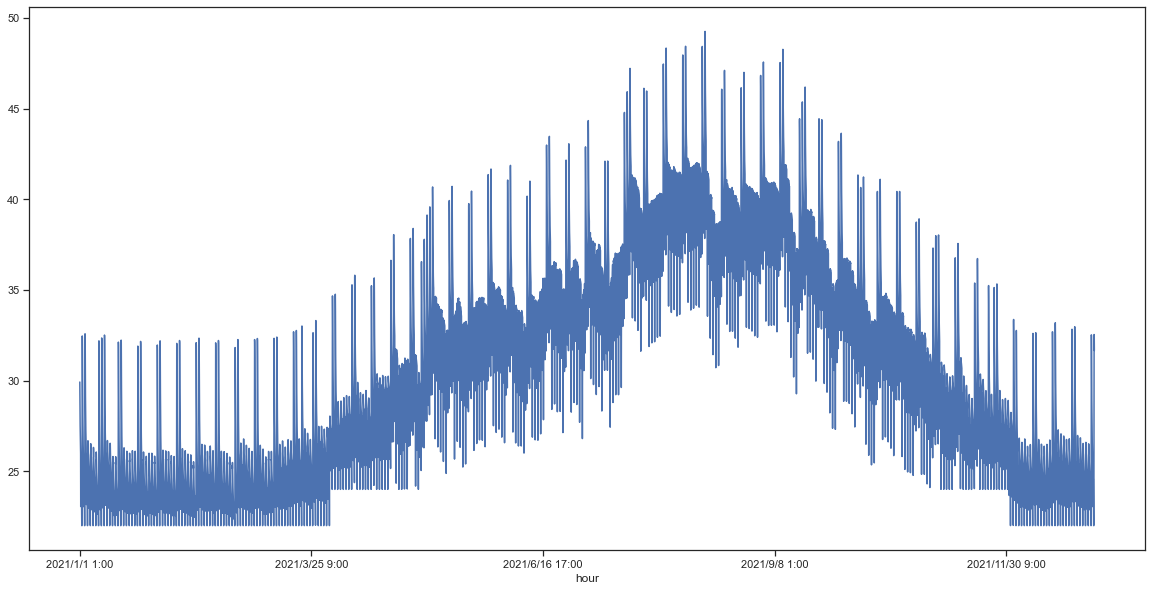

In [110]:
df['roomT'].plot.line(figsize=(20,10))

<AxesSubplot:>

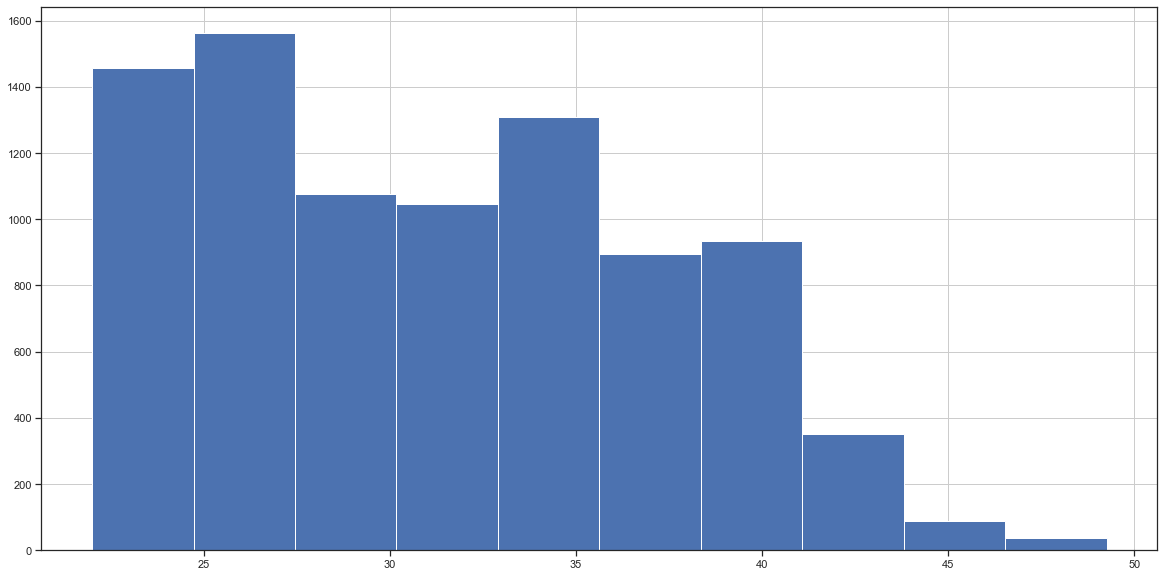

In [112]:
df['roomT'].hist(figsize=(20,10))

### 快適時間帯の割合は？

In [127]:
def calcPercentage(data,min,max):
    maxSatisfied = data[lambda x: x<max]
    satisfied = maxSatisfied[lambda x: x>min]
    percentage = len(satisfied)/len(data)*100
    return round(percentage,1)

In [128]:
calcPercentage(df['roomT'],25,28)

18.1

### visualizeの見栄えをよくする

#### Seabornは時間がかかりすぎ

<AxesSubplot:xlabel='hour', ylabel='roomT'>

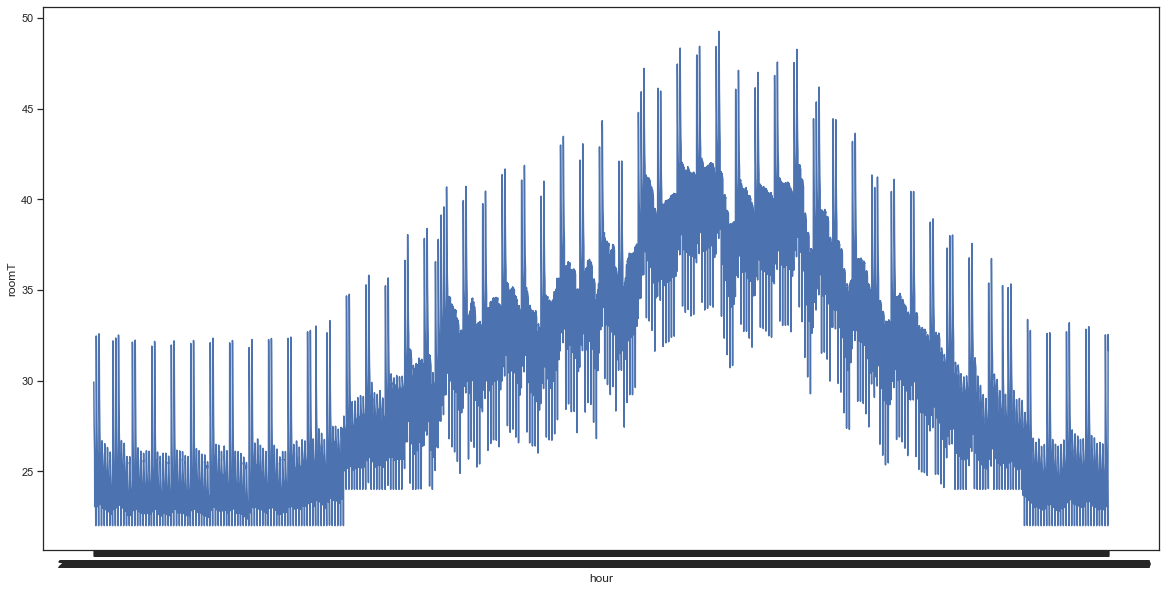

In [104]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x="hour", y="roomT")

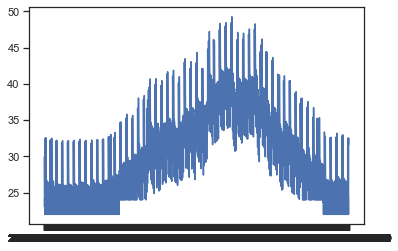

In [105]:
plt.plot(df.index,df["roomT"])